# Desafio de Projeto: Sistema de Recomendação por Imagens Digitais

## Introdução
Este projeto tem como objetivo desenvolver um sistema de recomendação de categorias de produtos com base em imagens digitais. Utilizando técnicas de aprendizado de máquina e processamento de imagens, o sistema é capaz de classificar diferentes categorias de produtos e gerar recomendações com base em imagens de entrada.

## Tecnologias Utilizadas
- [TensorFlow](https://www.tensorflow.org/): Framework de aprendizado de máquina.
- [TensorFlow Hub](https://tfhub.dev/): Repositório de modelos pré-treinados para TensorFlow.
- [Matplotlib](https://matplotlib.org/): Biblioteca de visualização de dados.
- [NumPy](https://numpy.org/): Biblioteca para manipulação de arrays.
- [Annoy](https://github.com/spotify/annoy): Biblioteca para busca eficiente de vizinhos mais próximos.
- [Kaggle](https://www.kaggle.com/): Plataforma de ciência de dados que fornece conjuntos de dados e competições.

## O que é feito no código
O código abrange várias etapas, desde o pré-processamento de dados até a criação e treinamento de um modelo de aprendizado profundo. As principais etapas incluem a organização de um conjunto de dados de imagens de produtos de moda disponível no Kaggle, a criação de um modelo de classificação de categorias de produtos utilizando o Bit ResNet50x3 do TensorFlow Hub, e a geração de recomendações com base em imagens fornecidas.

O script também inclui a criação de vetores de características para um conjunto de imagens, a construção de um índice Annoy para busca eficiente de vizinhos mais próximos e a visualização de recomendações com base em imagens de teste.

In [85]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import pickle
import glob
import requests

from annoy import AnnoyIndex
from IPython.display import Image as dispImage
from pathlib import Path
from tqdm import tqdm
from shutil import move
from PIL import Image

In [17]:
tqdm.pandas()

In [2]:
print("Versão do Tensorflow:", tf.__version__)
print("Versão do Tensorflow-Hub:", hub.__version__)

# Verifica a existência de GPUs
gpu = tf.config.list_physical_devices('GPU')
if gpu:
    # Mostra informações sobre a GPU
    name = tf.config.experimental.get_device_details(gpu[0])['device_name']
    print("GPU disponível:", name)
else:
    print("GPU não está disponível")

Versão do Tensorflow: 2.10.0
Versão do Tensorflow-Hub: 0.15.0
GPU disponível: NVIDIA GeForce RTX 3060


## Configuração Kaggle e Download de Dados (Ambiente Windows)

Este trecho de código facilita a instalação e configuração do ambiente Kaggle, especialmente útil no sistema operacional Windows. Abaixo estão as etapas detalhadas:

1. **Instalação e Configuração do Kaggle:**
   - Utiliza `%pip` para instalar e atualizar silenciosamente a biblioteca Kaggle.
   - Cria um diretório `.kaggle` no diretório do usuário para armazenar as credenciais.
   - Copia `kaggle.json` (com credenciais) para o novo diretório.

   **Observação:**
   - Certifique-se de ter o arquivo `kaggle.json` com suas próprias credenciais do Kaggle.

2. **Download do Conjunto de Dados:**
   - Utiliza `!kaggle datasets download` para baixar um conjunto específico (`paramaggarwal/fashion-product-images-small`).
   - Extrai o conteúdo do arquivo ZIP com `!tar -xf`.

**Importância:**
Configurar o ambiente Kaggle e baixar dados diretamente da plataforma simplifica o acesso a conjuntos de dados, facilitando análises e projetos de aprendizado de máquina.

**Adaptação para Outros Ambientes:**
   - Se estiver usando um sistema operacional diferente, ajuste o código conforme necessário.
   - O processo de configuração do Kaggle pode variar em ambientes não-Windows.


In [7]:
user_dir = os.path.expanduser("~")

In [ ]:
#hide
%pip install -q -U kaggle
%pip install --upgrade --force-reinstall --no-deps kaggle

!mkdir "{user_dir}/.kaggle"
!copy kaggle.json "{user_dir}/.kaggle/"

!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!tar -xf fashion-product-images-small.zip

In [10]:
if not os.path.exists('fashion_data'):
    os.mkdir('fashion_data')

## Preparação dos Dados para Treinamento

Este trecho de código realiza a organização dos dados necessária para o treinamento eficiente do modelo. A seguir, descrevemos cada etapa:

1. **Verificação e Criação de Diretórios:**
   - Verifica a existência do diretório 'fashion_data'. Se não existe, cria-o.
   - Utiliza `os.path.exists` para garantir a existência do diretório 'categories' em 'fashion_data'.
   - Se 'categories' não existe, cria esse diretório.

2. **Leitura e Manipulação do DataFrame:**
   - Carrega o arquivo CSV 'styles.csv', utilizando a biblioteca pandas, com foco nas colunas 'id' e 'masterCategory'.
   - Converte a coluna 'id' para o tipo string, evitando problemas futuros.

3. **Organização das Imagens por Categoria:**
   - Obtém a lista de todos os nomes de arquivos no diretório 'images'.
   - Itera sobre esses arquivos:
      - Extrai a categoria da imagem do DataFrame 'df' usando a coluna 'id'.
      - Cria subdiretórios em 'categories_path' para cada categoria, se ainda não existirem.
      - Move a imagem para o diretório correspondente à sua categoria.

   **Nota:**
   - Este processo é fundamental para categorizar as imagens, tornando mais eficiente a entrada de dados no modelo.

4. **Saída:**
   - Exibe a quantidade de imagens movidas para suas respectivas categorias.


In [11]:
df = pd.read_csv('styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')
all_images = os.listdir('images')
categories_path = 'fashion_data/categories'
count = 0

if not os.path.exists(categories_path):
    os.mkdir(categories_path)

for img in tqdm(all_images):
    category = df[df['id'] == img.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join(categories_path, category)):
        os.mkdir(os.path.join(categories_path, category))
    path_from = os.path.join('images/', img)
    path_to = os.path.join(categories_path, category, img)
    move(path_from, path_to)
    count += 1
print(f'Moved {count} images.')

100%|██████████| 44441/44441 [01:50<00:00, 401.40it/s]

Moved 44441 images.


## Configuração do Ambiente de Treinamento

Configuração do ambiente de treinamento, preparando os dados e definindo os parâmetros necessários. Abaixo estão as explicações detalhadas:

1. **Seleção do Modelo Pré-treinado:**
   - Utiliza o modelo pré-treinado 'm-r50x3' disponível no TensorFlow Hub.
   - A URL do modelo é armazenada na variável `MODULE_HANDLE`.

2. **Definição do Tamanho da Imagem e Batch Size:**
   - Define o tamanho da imagem de entrada como (224, 224).
   - Configura o tamanho do batch para 32.
   - Armazena essas configurações nas variáveis `IMAGE_SIZE` e `BATCH_SIZE`, respectivamente.

3. **Configuração dos Geradores de Imagens:**
   - Define os parâmetros de pré-processamento de imagem em `datagen_kwargs`, incluindo escala e divisão de validação.
   - Define os parâmetros de fluxo de dados em `dataflow_kwargs`, incluindo tamanho alvo e batch size.

4. **Geração de Dados de Validação:**
   - Utiliza o gerador de imagem da biblioteca TensorFlow para dados de validação.
   - Aplica as configurações definidas anteriormente, como rescale e tamanho alvo.
   - Os dados não são embaralhados (`shuffle = False`) para avaliação consistente.

5. **Augmentação de Dados (Opcional):**
   - Verifica se a augmentação de dados (`do_data_augmentation`) está ativada.
   - Se sim, configura um gerador de imagem para treinamento com operações como rotação, flip, deslocamento e zoom.
   - Se não, utiliza o mesmo gerador de dados de validação.

6. **Geração de Dados de Treinamento:**
   - Utiliza o gerador de imagem para dados de treinamento.
   - Embaralha os dados durante o treinamento (`shuffle = True`) se a augmentação estiver ativada.

**Observação:**
   - A augmentação de dados pode ser ajustada conforme necessário, dependendo da quantidade de dados disponíveis.


In [12]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print(f'Using {MODULE_HANDLE} with input size {IMAGE_SIZE}')
BATCH_SIZE = 32 
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [13]:
data_dir = categories_path

In [14]:
datagen_kwargs = dict(rescale = 1. / 255, validation_split = .20)
dataflow_kwargs = dict(target_size = IMAGE_SIZE, batch_size = BATCH_SIZE,
                   interpolation = "bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset = "validation", shuffle = False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range = 40,
      horizontal_flip = True,
      width_shift_range = 0.2, height_shift_range = 0.2,
      shear_range = 0.2, zoom_range = 0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle = True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


## Construção e Treinamento do Modelo de Recomendação

Este trecho de código trata da construção e treinamento do modelo de recomendação por meio da transferência de aprendizado. Abaixo estão as explicações detalhadas:

1. **Construção do Modelo:**
   - Utiliza a biblioteca TensorFlow para construir o modelo sequencial.
   - Configura a camada de entrada com o tamanho da imagem e três canais de cor.
   - Adiciona a camada de modelo pré-treinado do TensorFlow Hub (Bit-M R50x3) como uma camada não treinável.
   - Introduz camadas de dropout para regularização.
   - Adiciona duas camadas densas, sendo a última com unidades igual ao número de classes no conjunto de treinamento.
   - Imprime um resumo do modelo construído.

2. **Configuração do Otimizador e da Função de Perda:**
   - Define a taxa de aprendizado inicial (`lr`) com base no tamanho do lote.
   - Configura os pontos de mudança (`boundaries`) e valores de taxa de aprendizado para uma programação de taxa de aprendizado constante.
   - Utiliza o otimizador estocástico de gradiente descendente (SGD) com momentum.
   - Define a função de perda como Categorical Crossentropy.

3. **Compilação do Modelo:**
   - Compila o modelo com o otimizador, a função de perda e métricas de avaliação.
   - Está pronto para ser treinado.

4. **Treinamento do Modelo:**
   - Utiliza o conjunto de treinamento gerado anteriormente (`train_generator`) e o conjunto de validação (`valid_generator`).
   - Treina o modelo por 5 épocas.
   - Armazena as métricas de treinamento e validação em um histórico (`hist`).
   - O modelo agora está treinado e pronto para ser usado na recomendação de imagens.

**Observação:**
   - A regularização com camadas de dropout ajuda a prevenir o overfitting durante o treinamento.
   - Os hiperparâmetros, como a taxa de aprendizado, podem ser ajustados para otimizar o desempenho do modelo.
   - O histórico de treinamento (`hist`) pode ser utilizado para análise de desempenho e ajuste adicional.


In [15]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = IMAGE_SIZE + (3,)),
        hub.KerasLayer(MODULE_HANDLE, trainable = False),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(N_FEATURES,
                            kernel_regularizer = tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(train_generator.num_classes,
                            kernel_regularizer = tf.keras.regularizers.l2(0.0001))
])

model.build((None,) + IMAGE_SIZE + (3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212,748,999
Trainable params: 1,574,919
Non-trainable params: 211,174,080
_________________________________________

In [16]:
# Definição do otimizados e da perda
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Redução da taxa de aprendizado por um fator de 10
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries = SCHEDULE_BOUNDARIES,                                                                    values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate = lr_schedule, momentum = 0.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
model.compile(optimizer = optimizer,
              loss = loss_fn,
              metrics=['accuracy'])

In [ ]:
hist = model.fit(
    train_generator,
    epochs = 5,
    validation_data = valid_generator
).history

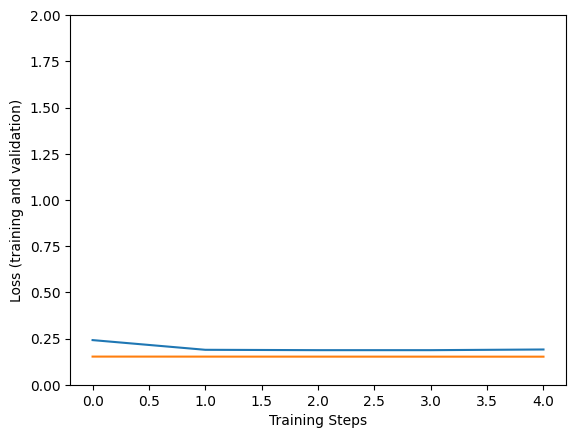

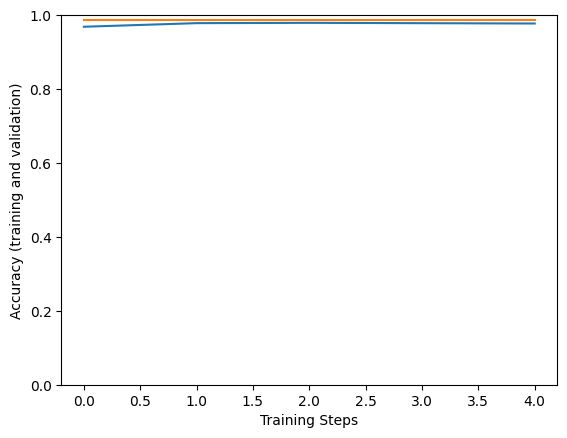

In [22]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

## Salvamento do Modelo e Preparação para Extração de Recursos

São realizadas as seguintes tarefas:

1. **Criação de Diretório para Salvamento:**
   - Verifica se o diretório 'ImgSim' já existe.
   - Caso não exista, cria o diretório para salvar os modelos.

2. **Salvamento do Extrator de Recursos (Feature Extractor):**
   - Cria um modelo separado (`feature_extractor`) que consiste nas camadas até a penúltima camada do modelo original.
   - Salva esse extrator de recursos no formato TensorFlow SavedModel no diretório 'ImgSim/bit_feature_extractor'.

3. **Salvamento do Modelo Completo:**
   - Salva o modelo completo no formato TensorFlow SavedModel no diretório 'ImgSim/bit_model'.

4. **Preparação de Caminhos de Imagens para Teste:**
   - Lista os caminhos de todas as imagens no diretório 'categories_path' e embaralha-os.
   - Utiliza um gerador de números aleatórios (`rng`) para garantir aleatoriedade.

5. **Definição de Função para Carregamento de Imagem:**
   - Define a função `load_img(path)` para carregar e pré-processar uma imagem a ser usada nos testes.

**Observação:**
   - O salvamento do extrator de recursos permite o uso independente para gerar representações de características.
   - O modelo completo também é salvo para possível restauração e reutilização sem a necessidade de treinamento.
   - A lista embaralhada de caminhos de imagens pode ser utilizada para testes e avaliação do modelo treinado.


In [ ]:
if not os.path.exists('ImgSim'):
    os.mkdir('ImgSim')

feature_extractor = tf.keras.Model(inputs = model.inputs, outputs = model.layers[-3].output)
feature_extractor.save('ImgSim/bit_feature_extractor', save_format = 'tf')

saved_model_path = 'ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

In [24]:
img_paths = []
rng = np.random.default_rng(42)

for path in Path(categories_path).rglob('*.jpg'):
    img_paths.append(path)
rng.shuffle(img_paths)

In [25]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    return img

## Carregamento do Modelo e Extração de Recursos

Neste trecho:

1. **Carregamento do Modelo:**
   - Verifica a flag `TRANSFER_LEARNING_FLAG`.
   - Se `TRANSFER_LEARNING_FLAG` for verdadeiro, carrega o extrator de recursos previamente salvo (`'ImgSim/bit_feature_extractor'`).
   - Caso contrário, carrega o modelo pré-treinado a partir do TensorFlow Hub (`"https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"`).

2. **Extração de Recursos e Salvamento:**
   - Utiliza o modelo ou extrator carregado para gerar vetores de características para as imagens no conjunto de dados.
   - Os vetores de características são salvos em arquivos `.npz` no diretório 'img_vectors'.
   - A extração de recursos é realizada apenas para as primeiras 5000 imagens (`img_paths[:5000]`) para fins de demonstração.


In [26]:
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
    module = tf.keras.models.load_model('ImgSim/bit_feature_extractor')
else:
    module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
    module = hub.load(module_handle)

In [27]:
imgvec_path = 'img_vectors'

if not os.path.exists(imgvec_path):
    os.mkdir(imgvec_path)

In [28]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [06:05<00:00, 13.68it/s]


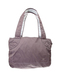

In [29]:
test_img = 'fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

## Configuração e Construção do Índice Annoy

1. **Leitura e Pré-processamento de Dados:**
   - Leitura do arquivo CSV contendo informações sobre estilos (`styles.csv`).
   - Conversão da coluna 'id' para string.
   - Salvamento do DataFrame resultante no diretório `'ImgSim'`.

2. **Construção do Índice Annoy:**
   - Utiliza a biblioteca Annoy para criar um índice que permite realizar buscas por similaridade nos vetores de características.
   - Configuração dos parâmetros Annoy, como número de dimensões (`dims`), número de vizinhos mais próximos (`n_nearest_neighbors`), e número de árvores (`trees`).

3. **Leitura dos Vetores de Características:**
   - Leitura de todos os arquivos `.npz` contendo os vetores de características extraídos.

4. **Construção do Índice Annoy (Continuação):**
   - Adição dos vetores de características ao índice Annoy.

5. **Salvamento do Índice Annoy e Outras Estruturas de Dados:**
   - Salvamento do índice Annoy em um arquivo (`'t.ann'`).
   - Salvamento de outras estruturas de dados, como mapeamento de índice para nome de arquivo e mapeamento de índice para ID de produto, utilizando a biblioteca pickle.

**Observações:**
   - O índice Annoy permite buscar imagens semanticamente semelhantes com eficiência.
   - As estruturas de dados salvas são cruciais para associar resultados de busca com informações relevantes, como nomes de arquivos e IDs de produtos.


In [30]:
root_path = 'ImgSim'

In [ ]:
styles = pd.read_csv('styles.csv', on_bad_lines='warn')
styles['id'] = styles['id'].astype('str')
styles.to_csv(root_path + '/styles.csv', index=False)

In [32]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [33]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors 
allfiles = glob.glob('img_vectors/*.npz')

t = AnnoyIndex(dims, metric = 'angular')

In [34]:
for findex, fname in tqdm(enumerate(allfiles)):
    file_vector = np.loadtxt(fname)
    file_name = os.path.basename(fname).split('.')[0]
    file_index_to_file_name[findex] = file_name
    file_index_to_file_vector[findex] = file_vector
    try:
        file_index_to_product_id[findex] = match_id(file_name)
    except IndexError:
        pass 
    t.add_item(findex, file_vector)

5000it [00:42, 118.02it/s]


In [35]:
t.build(trees)
t.save('t.ann')

True

In [36]:
t.save(root_path + '/indexer.ann')
pickle.dump(file_index_to_file_name, open(root_path + "/file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(root_path + "/file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(root_path + "/file_index_to_product_id.p", "wb"))

## Download e Redimensionamento de Imagens

Neste trecho, imagens de produtos são baixadas a partir de URLs específicas e salvas localmente. As imagens são, em seguida, redimensionadas para um tamanho padrão antes de serem exibidas.

1. **URLs das Imagens:**
   - São fornecidas quatro URLs de produtos diferentes (bolsa, relógio, tênis e cosméticos).

2. **Download das Imagens:**
   - A função `img_downloader` é utilizada para baixar cada imagem e salvá-las no diretório 'downloads'.

3. **Caminho das Imagens:**
   - Caminhos locais para as imagens baixadas são definidos (`bolsa`, `relogio`, `tenis` e `cosmeticos`).

4. **Redimensionamento e Exibição:**
   - As imagens são redimensionadas para um tamanho padrão de 224x224 pixels utilizando a função `img_show`.
   - As imagens redimensionadas são então exibidas lado a lado em subplots, cada uma com seu título correspondente.

Esse processo simula a apresentação de produtos para os quais se deseja obter recomendações com base em características visuais.

In [ ]:
def img_downloader(img_addr, img_name):
    response = requests.get(img_addr)
    with open(img_name + '.jpg', 'wb') as img_file:
        img_file.write(response.content)

In [ ]:
def img_show(img_path, width):
    img = Image.open(img_path)
    wpercent = (width/float(img.size[0]))
    hsize = int((float(img.size[1])*float(wpercent)))
    img = img.resize((width, hsize), Image.Resampling.LANCZOS)
    return img

In [55]:
download_path = 'downloads'

if not os.path.exists(download_path):
    os.mkdir(download_path)

In [67]:
# URL da imagem
addr_1 = 'https://constance.vtexassets.com/arquivos/ids/2166168-1200-auto?v=638170747925830000&width=1200&height=auto&aspect=true'
addr_2 = 'https://cdn.eclock.com.br/media/catalog/product/cache/1/image/1000x/9df78eab33525d08d6e5fb8d27136e95/r/e/relogio-mondaine-feminino-53817lpmvpe2-015.jpg'
addr_3 = 'https://m.media-amazon.com/images/I/41P9VNxmD6L._AC_SL1000_.jpg'
addr_4 = 'https://m.media-amazon.com/images/I/618gymsnHTS._AC_SX679_.jpg'

# Baixar a imagens
img_downloader(addr_1, download_path + '/bolsa')
img_downloader(addr_2, download_path + '/relogio')
img_downloader(addr_3, download_path + '/tenis')
img_downloader(addr_4, download_path + '/cosmeticos')

In [83]:
# Caminho da imagem
bolsa = download_path + '/bolsa.jpg'
relogio = download_path + '/relogio.jpg'
tenis = download_path + '/tenis.jpg'
cosmeticos = download_path + '/cosmeticos.jpg'

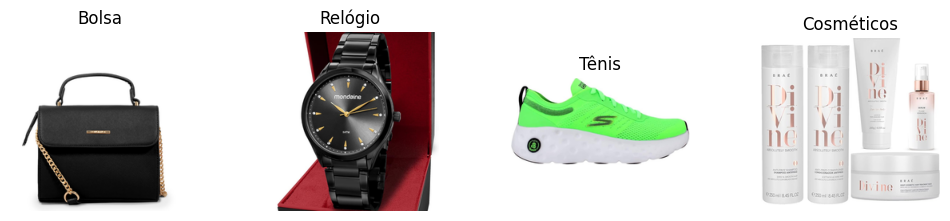

In [84]:
# Redimensionar as imagens
img_bolsa = img_show(bolsa, 224)
img_relogio = img_show(relogio, 224)
img_tenis = img_show(tenis, 224)
img_cosmeticos = img_show(cosmeticos, 224)

# Criar subplots com títulos acima das imagens
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
fig.subplots_adjust(wspace=0.4)

imagens = [img_bolsa, img_relogio, img_tenis, img_cosmeticos]
titulos = ['Bolsa', 'Relógio', 'Tênis', 'Cosméticos']

for ax, img, titulo in zip(axs, imagens, titulos):
    ax.imshow(img)
    ax.set_title(titulo)
    ax.axis('off')

plt.show()

In [78]:
vec_bolsa = np.squeeze(module(load_img(bolsa)))
vec_relogio = np.squeeze(module(load_img(relogio)))
vec_tenis = np.squeeze(module(load_img(tenis)))
vec_cosmeticos = np.squeeze(module(load_img(cosmeticos)))

## Recomendações de Produtos

A função `plt_recommendation` é responsável por exibir recomendações de produtos com base em vetores de características visuais. Ela utiliza a biblioteca Annoy para buscar os produtos mais semelhantes a um vetor de imagem fornecido.

1. **Parâmetros:**
   - `categories_path`: O caminho para o diretório contendo as imagens categorizadas.
   - `img_vector`: O vetor de características visuais da imagem de referência.
   - `top_k`: O número de produtos semelhantes a serem recomendados.

2. **Processo:**
   - Um dicionário (`path_dict`) é criado para mapear os nomes dos arquivos de imagem para seus caminhos completos.
   - Usando a função `get_nns_by_vector` do Annoy, os índices dos produtos mais semelhantes são recuperados.
   - As recomendações são então exibidas em uma grade de subplots, cada uma com a imagem do produto e suas informações.

Esse processo simula a recomendação de produtos visualmente semelhantes com base em um produto de referência.


In [50]:
def plt_recommendation(categories_path, img_vector, top_k):
    path_dict = {}
    for path in Path(categories_path).rglob('*.jpg'):
        path_dict[path.name] = path

    nns = t.get_nns_by_vector(img_vector, n = top_k)
    plt.figure(figsize=(20, 10))
    for i in range(top_k):
        x = file_index_to_file_name[nns[i]]
        x = path_dict[x + '.jpg']
        y = file_index_to_product_id[nns[i]]
        title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
        plt.subplot(1, top_k, i+1)
        plt.title(title)
        plt.imshow(mpimg.imread(x))
        plt.axis('off')
    plt.tight_layout()

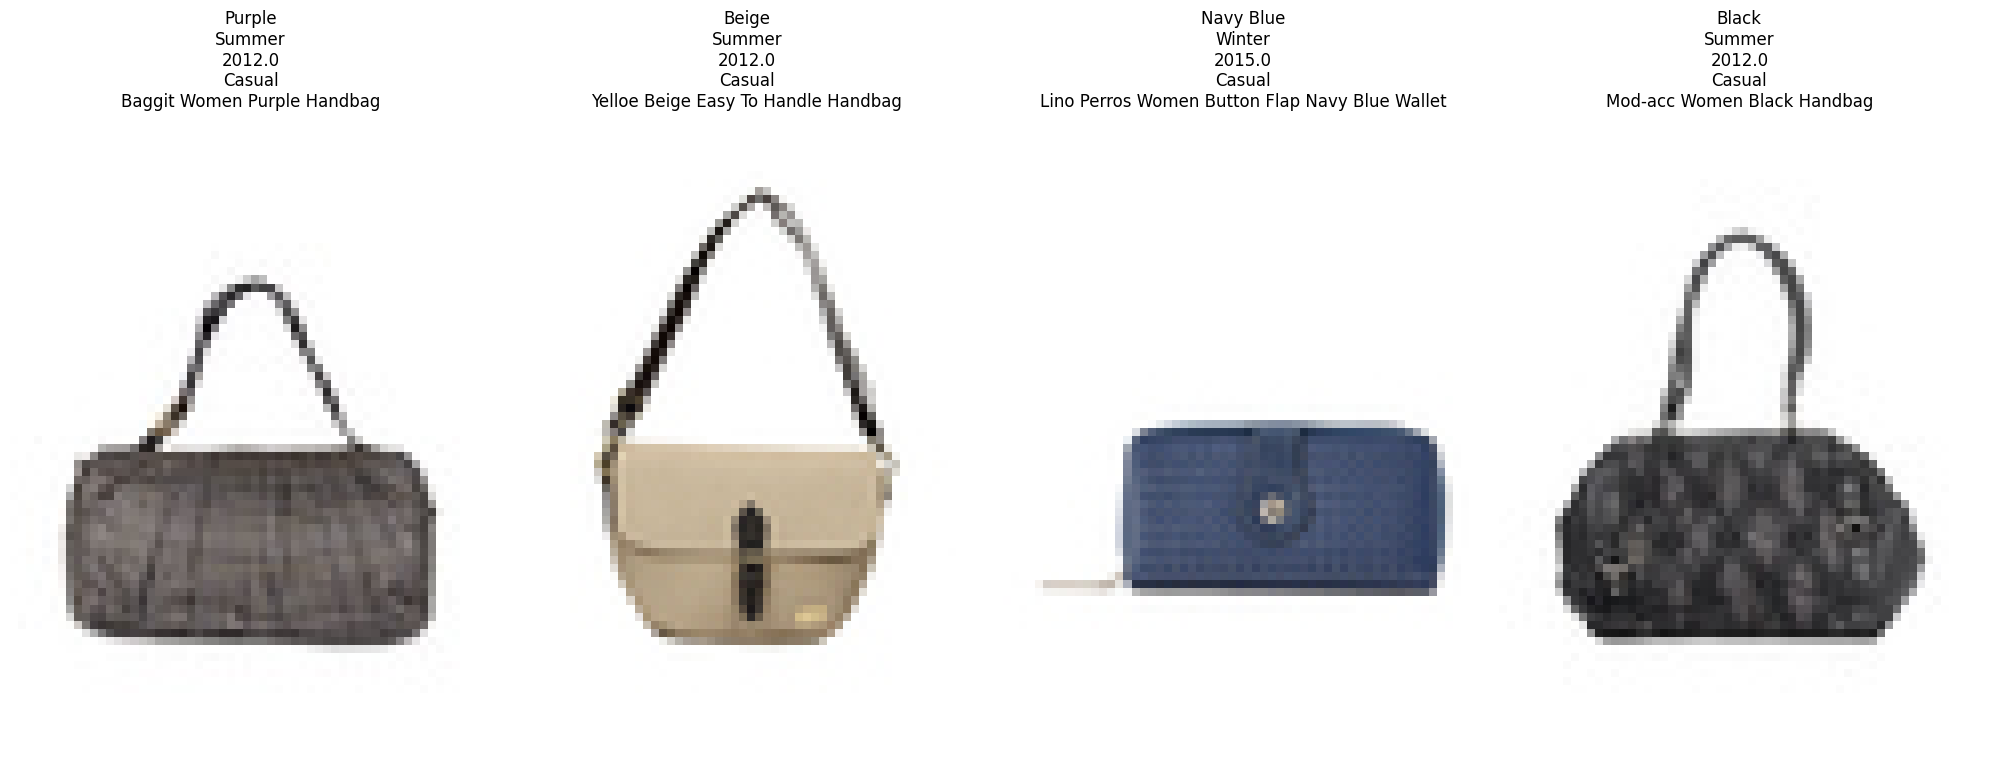

In [79]:
plt_recommendation(categories_path, vec_bolsa, 4)

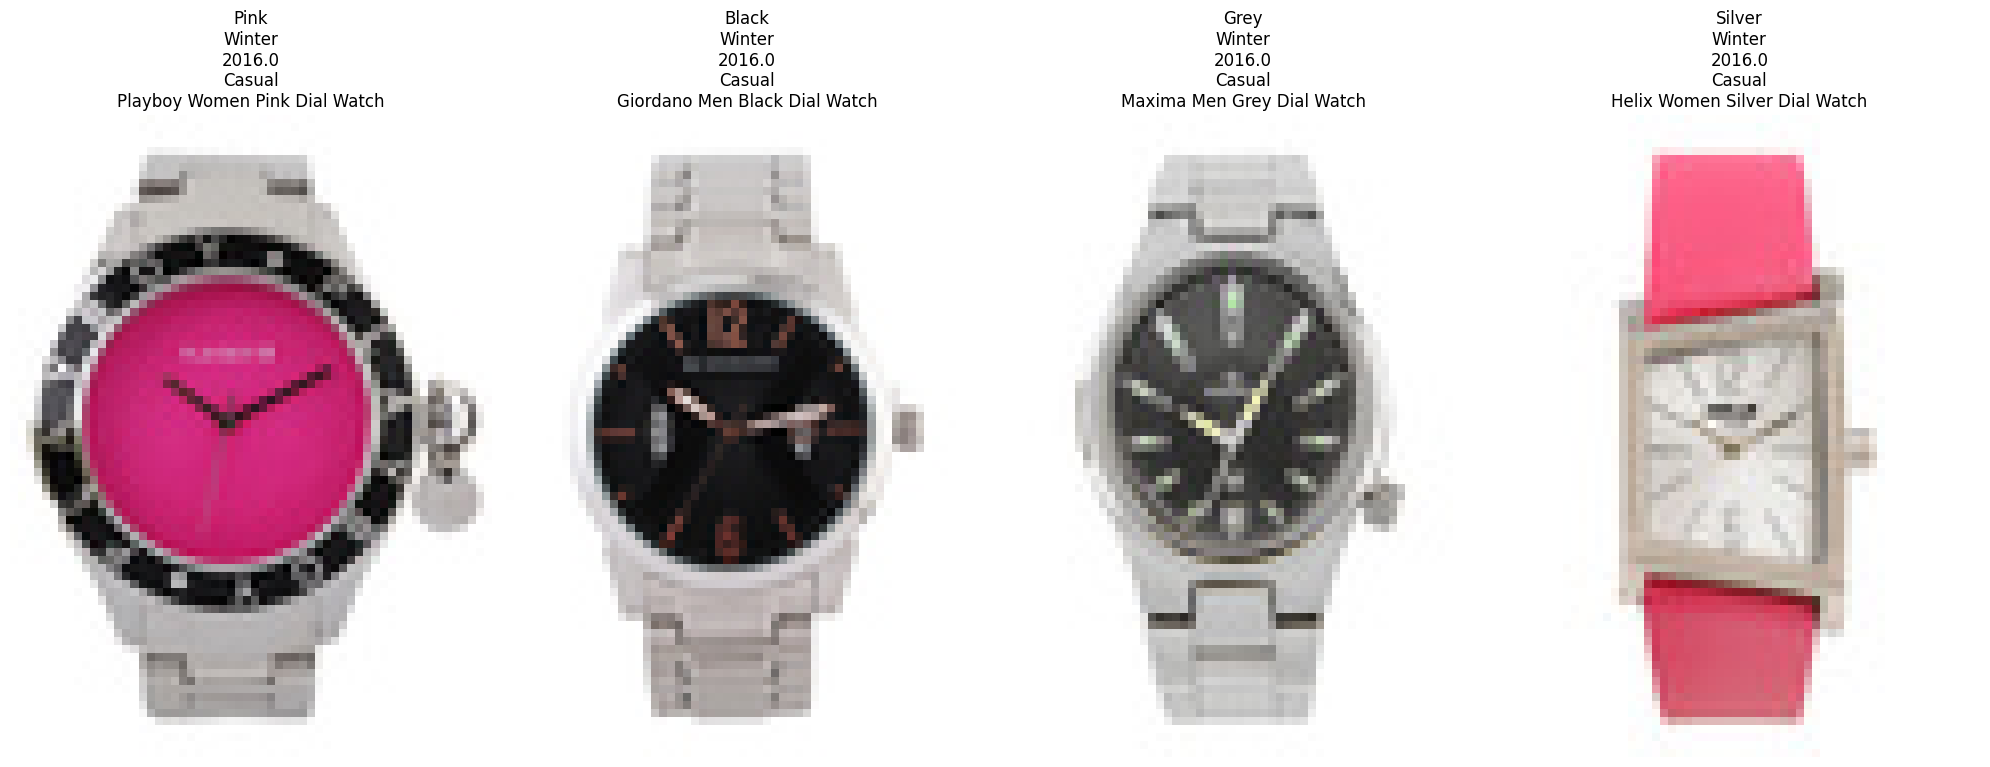

In [80]:
plt_recommendation(categories_path, vec_relogio, 4)

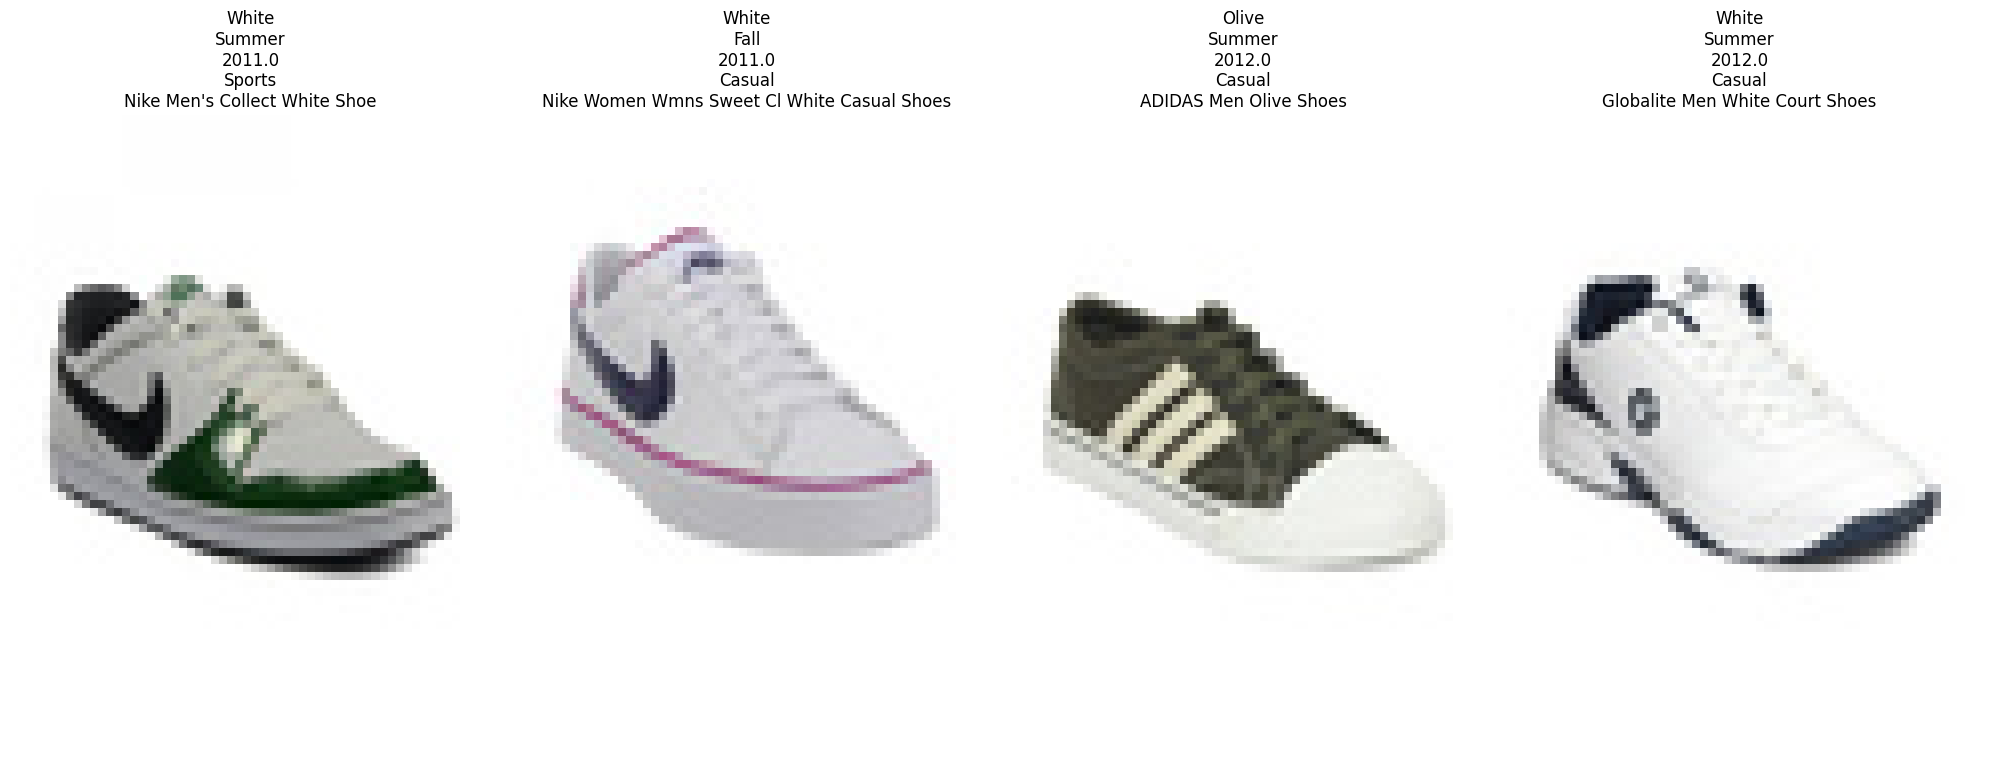

In [81]:
plt_recommendation(categories_path, vec_tenis, 4)

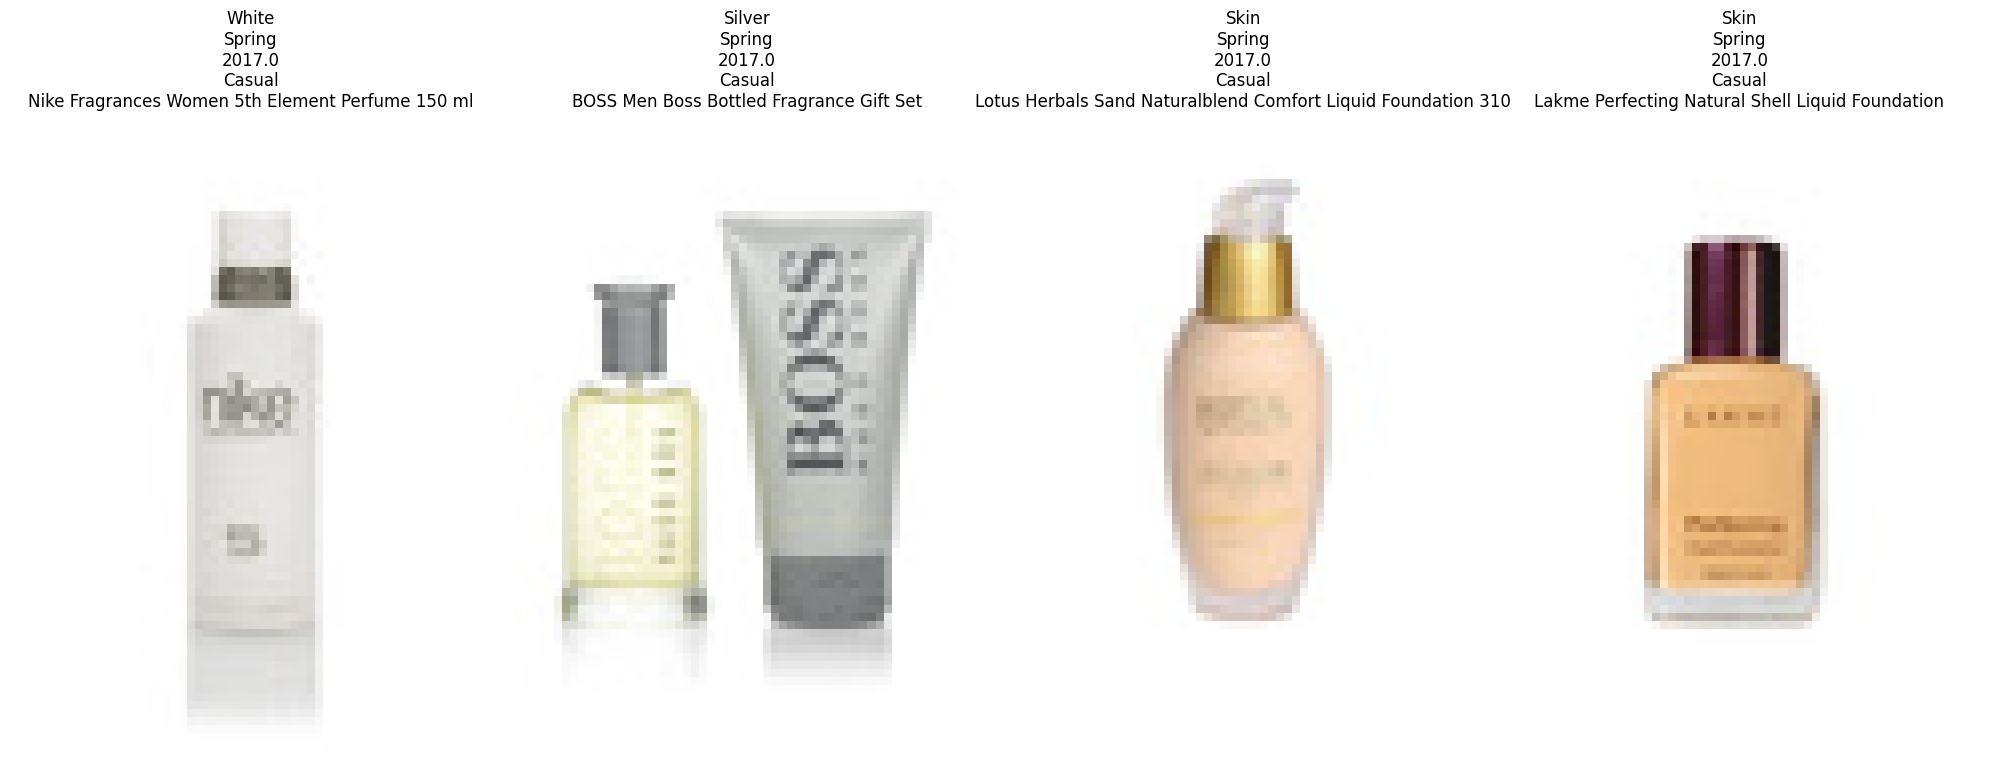

In [82]:
plt_recommendation(categories_path, vec_cosmeticos, 4)

Este projeto faz parte do Desafio de Projeto da Formação Machine Learning Specialist da Digital Innovation One (DIO). Aqui, desenvolvemos um sistema de recomendação de produtos com base em características visuais usando aprendizado de transferência e Annoy.

### Tecnologias Utilizadas:
- Python
- TensorFlow
- TensorFlow Hub
- Annoy
- Pandas
- Matplotlib
- Pillow

### Passos Principais:
1. **Preparação de Dados:**
   - Organização e categorização de imagens do conjunto de dados.

2. **Treinamento do Modelo:**
   - Utilização de um modelo de aprendizado de transferência com Bit-m (m-R50x3) do TensorFlow Hub.
   - Treinamento do modelo para extrair características visuais.

3. **Annoy e Recomendações:**
   - Uso da biblioteca Annoy para buscar produtos visualmente semelhantes.
   - Exibição de recomendações com base nas imagens de referência.

4. **Aplicações Práticas:**
   - Demonstração de como o modelo pode ser aplicado a novas imagens.

### Agradecimentos:
Este projeto foi desenvolvido como parte da Formação Machine Learning Specialist oferecida pela DIO. Agradececimento à DIO por proporcionar oportunidades de aprendizado prático e desafiador.